In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers[torch] datasets accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.wh

In [3]:
import pandas as pd
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/CZ4034/train_labeled_lyrics_english.csv')
train_df = train_df.iloc[:, 1:]
train_df

,Unnamed: 0,artist,album,track,track_id,lyrics,duration,genre,emotion,intensity
0,18924,Linkin Park,LIVING THINGS: Acapellas and Instrumentals,SKIN TO BONE - Acapella,0jw00DFjpx3AjcPtVCS1st,"Skin to bone, steel to rust\nAsh to ashes, dus...",2 minutes 37 seconds,"['alternative metal', 'nu metal', 'post-grunge...",acceptance,low
1,22125,Ava Max,So Am I (The Remixes),So Am I - Toby Green Remix,26c18xZN2XSjK50hoYWQrz,Do you ever feel like a misfit?\nEverything in...,2 minutes 46 seconds,['pop'],acceptance,low
2,3717,Benson Boone,Hits 2024,Crazy,3lJkIVh6lYW0pERAtwu4kJ,Something don't feel right\nYou got a way with...,3 minutes 7 seconds,['singer-songwriter pop'],acceptance,low
3,12691,Billie Eilish,Sunset Vibes,Clown,6FAfVzdBlNrvks8hiOokCl,I guess it's funnier from where you're standin...,3 minutes 41 seconds,"['art pop', 'pop']",acceptance,low
4,13966,Lana Del Rey,Lust For Life,Get Free,761QvVHTibYjEi2r6A4g4Q,"Finally, I'm crossing the threshold\nFrom the ...",5 minutes 34 seconds,"['art pop', 'pop']",acceptance,low
...,...,...,...,...,...,...,...,...,...,...
1079,9179,Black Sabbath,The Eternal Idol (Deluxe Edition),The Shining (2009 Remaster),1lSUiRmzS2c1KGrZqaeMWV,There's a man who sees all there is to see\nWh...,5 minutes 58 seconds,"['album rock', 'alternative metal', 'birmingha...",vigilance,high
1080,22976,Slayer,Show No Mercy,Fight Till Death,5xFqDS7kANSCyzne6yqjIV,Metal and men clash once more to the end\nWarr...,3 minutes 37 seconds,"['alternative metal', 'death metal', 'groove m...",vigilance,high
1081,22627,Keshi,Sex Music 2022,First,6YY1WmsYGgTAwFWab6jHAY,Promise that you won't kiss and tell\nI'm for ...,3 minutes 26 seconds,['chill r&b'],vigilance,high
1082,16555,Elton John,Blue Moves,If There's A God In Heaven (What's He Waiting ...,0jfP8jD5xZBWXUJ0H36UKz,"Torn from their families, mothers go hungry\nT...",4 minutes 25 seconds,"['glam rock', 'mellow gold', 'piano rock', 'ro...",vigilance,high


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 32
id2label = {
    "0": "serenity",
    "1": "joy",
    "2": "ecstasy",
    "3": "love",
    "4": "acceptance",
    "5": "trust",
    "6": "admiration",
    "7": "submission",
    "8": "apprehension",
    "9": "fear",
    "10": "terror",
    "11": "awe",
    "12": "distraction",
    "13": "surprise",
    "14": "amazement",
    "15": "disapproval",
    "16": "pensiveness",
    "17": "sadness",
    "18": "grief",
    "19": "remorse",
    "20": "boredom",
    "21": "disgust",
    "22": "loathing",
    "23": "contempt",
    "24": "annoyance",
    "25": "anger",
    "26": "rage",
    "27": "aggressiveness",
    "28": "interest",
    "29": "anticipation",
    "30": "vigilance",
    "31": "optimism"

}

label2id = {
    "serenity": 0,
    "joy": 1,
    "ecstasy": 2,
    "love": 3,
    "acceptance": 4,
    "trust": 5,
    "admiration": 6,
    "submission": 7,
    "apprehension": 8,
    "fear": 9,
    "terror": 10,
    "awe": 11,
    "distraction": 12,
    "surprise": 13,
    "amazement": 14,
    "disapproval": 15,
    "pensiveness": 16,
    "sadness": 17,
    "grief": 18,
    "remorse": 19,
    "boredom": 20,
    "disgust": 21,
    "loathing": 22,
    "contempt": 23,
    "annoyance": 24,
    "anger": 25,
    "rage": 26,
    "aggressiveness": 27,
    "interest": 28,
    "anticipation": 29,
    "vigilance": 30,
    "optimism": 31
}


In [ ]:
train_df["label"] = train_df["emotion"].apply(lambda x: label2id[x])
train_df

,Unnamed: 0,artist,album,track,track_id,lyrics,duration,genre,emotion,intensity,label
0,18924,Linkin Park,LIVING THINGS: Acapellas and Instrumentals,SKIN TO BONE - Acapella,0jw00DFjpx3AjcPtVCS1st,"Skin to bone, steel to rust\nAsh to ashes, dus...",2 minutes 37 seconds,"['alternative metal', 'nu metal', 'post-grunge...",acceptance,low,4
1,22125,Ava Max,So Am I (The Remixes),So Am I - Toby Green Remix,26c18xZN2XSjK50hoYWQrz,Do you ever feel like a misfit?\nEverything in...,2 minutes 46 seconds,['pop'],acceptance,low,4
2,3717,Benson Boone,Hits 2024,Crazy,3lJkIVh6lYW0pERAtwu4kJ,Something don't feel right\nYou got a way with...,3 minutes 7 seconds,['singer-songwriter pop'],acceptance,low,4
3,12691,Billie Eilish,Sunset Vibes,Clown,6FAfVzdBlNrvks8hiOokCl,I guess it's funnier from where you're standin...,3 minutes 41 seconds,"['art pop', 'pop']",acceptance,low,4
4,13966,Lana Del Rey,Lust For Life,Get Free,761QvVHTibYjEi2r6A4g4Q,"Finally, I'm crossing the threshold\nFrom the ...",5 minutes 34 seconds,"['art pop', 'pop']",acceptance,low,4
...,...,...,...,...,...,...,...,...,...,...,...
1079,9179,Black Sabbath,The Eternal Idol (Deluxe Edition),The Shining (2009 Remaster),1lSUiRmzS2c1KGrZqaeMWV,There's a man who sees all there is to see\nWh...,5 minutes 58 seconds,"['album rock', 'alternative metal', 'birmingha...",vigilance,high,30
1080,22976,Slayer,Show No Mercy,Fight Till Death,5xFqDS7kANSCyzne6yqjIV,Metal and men clash once more to the end\nWarr...,3 minutes 37 seconds,"['alternative metal', 'death metal', 'groove m...",vigilance,high,30
1081,22627,Keshi,Sex Music 2022,First,6YY1WmsYGgTAwFWab6jHAY,Promise that you won't kiss and tell\nI'm for ...,3 minutes 26 seconds,['chill r&b'],vigilance,high,30
1082,16555,Elton John,Blue Moves,If There's A God In Heaven (What's He Waiting ...,0jfP8jD5xZBWXUJ0H36UKz,"Torn from their families, mothers go hungry\nT...",4 minutes 25 seconds,"['glam rock', 'mellow gold', 'piano rock', 'ro...",vigilance,high,30


# **OVERSAMPLING**

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

In [ ]:
x = train_df.iloc[:, 5] # lyrics column
y = train_df.iloc[:, 10] # label column
print(len(x), len(y))
print(x)
print(y)

1084 1084
0       Skin to bone, steel to rust\nAsh to ashes, dus...
1       Do you ever feel like a misfit?\nEverything in...
2       Something don't feel right\nYou got a way with...
3       I guess it's funnier from where you're standin...
4       Finally, I'm crossing the threshold\nFrom the ...
                              ...                        
1079    There's a man who sees all there is to see\nWh...
1080    Metal and men clash once more to the end\nWarr...
1081    Promise that you won't kiss and tell\nI'm for ...
1082    Torn from their families, mothers go hungry\nT...
1083    No regret for the confidence betrayed\nNo more...
Name: lyrics, Length: 1084, dtype: object
0        4
1        4
2        4
3        4
4        4
        ..
1079    30
1080    30
1081    30
1082    30
1083    30
Name: label, Length: 1084, dtype: int64


In [ ]:
type(x), len(x), x[0]

(pandas.core.series.Series,
 1084,
 "Skin to bone, steel to rust\nAsh to ashes, dust to dust\nLet tomorrow have its way\nWith the promises we made\nSkin to bone, steel to rust\n♪\nAsh to ashes, dust to dust\nYour deception, my disgust\nWhen your name is finally drawn\nI'll be happy that you're gone\nAsh to ashes, dust to dust\nAh-ah-ah-ah-ah-ah\nAsh to ashes, dust to dust\nAh-ah-ah-ah-ah-ah\nSkin to bone and steel to rust\nRight to left left to right\nNight to day and day to night\nAs the starlight fades to gray\nI'll be marching far away\nRight to left and left to right\nAh-ah-ah-ah-ah-ah\nAsh to ashes, dust to dust\nAh-ah-ah-ah-ah-ah\nSkin to bone and steel to rust\nLet tomorrow have its way\nWith the promises betrayed\nSkin to bone and steel to rust\nSkin to bone and steel to rust\nSkin to bone and steel to rust\n")

In [ ]:
type(y), len(y), y

(pandas.core.series.Series,
 1084,
 0        4
 1        4
 2        4
 3        4
 4        4
         ..
 1079    30
 1080    30
 1081    30
 1082    30
 1083    30
 Name: label, Length: 1084, dtype: int64)

In [ ]:
# x_str:  row index
x_str = np.array(range(len(x))).reshape(-1, 1)
len(x_str), x_str

(1084,
 array([[   0],
        [   1],
        [   2],
        ...,
        [1081],
        [1082],
        [1083]]))

In [ ]:
print('Original dataset shape %s' % Counter(y))
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(x_str, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({2: 139, 1: 117, 27: 93, 18: 76, 3: 56, 24: 52, 29: 51, 22: 51, 17: 49, 16: 48, 25: 37, 31: 37, 6: 34, 8: 33, 9: 30, 26: 27, 21: 26, 19: 23, 10: 17, 30: 15, 5: 14, 28: 10, 7: 10, 0: 9, 11: 8, 23: 8, 4: 5, 15: 4, 20: 2, 13: 2, 12: 1})
Resampled dataset shape Counter({4: 139, 6: 139, 27: 139, 25: 139, 24: 139, 29: 139, 8: 139, 11: 139, 20: 139, 23: 139, 15: 139, 21: 139, 12: 139, 2: 139, 9: 139, 18: 139, 28: 139, 1: 139, 22: 139, 3: 139, 31: 139, 16: 139, 26: 139, 19: 139, 17: 139, 0: 139, 7: 139, 13: 139, 10: 139, 5: 139, 30: 139})


# There is no songs labeled with 'amazement'

In [ ]:
print(f"{list(set(range(31)) - set(Counter(y_res).keys()))} is not in the resampled dataset")

[14] is not in the resampled dataset


In [ ]:
# convert resampled row indexes back into lyrics
X_res = [x[i] for i in X_res.flatten()]

In [ ]:
resampled_df = pd.DataFrame(X_res, columns=['lyrics'])
resampled_df['label'] = y_res
resampled_df['emotion'] = [id2label[str(y)] for y in y_res]
# resampled_df['intensity'] = [intensity[id2intensity[str(y)]] for y in y_res]
resampled_df

,lyrics,label,emotion
0,"Skin to bone, steel to rust\nAsh to ashes, dus...",4,acceptance
1,Do you ever feel like a misfit?\nEverything in...,4,acceptance
2,Something don't feel right\nYou got a way with...,4,acceptance
3,I guess it's funnier from where you're standin...,4,acceptance
4,"Finally, I'm crossing the threshold\nFrom the ...",4,acceptance
...,...,...,...
4304,I love it when you just don't care\nI love it ...,31,optimism
4305,It's an illusion\nThere's too much confusion\n...,31,optimism
4306,"Under my skin, beneath my fingertips\nYou slip...",31,optimism
4307,Came in from a rainy Thursday on the avenue\nT...,31,optimism


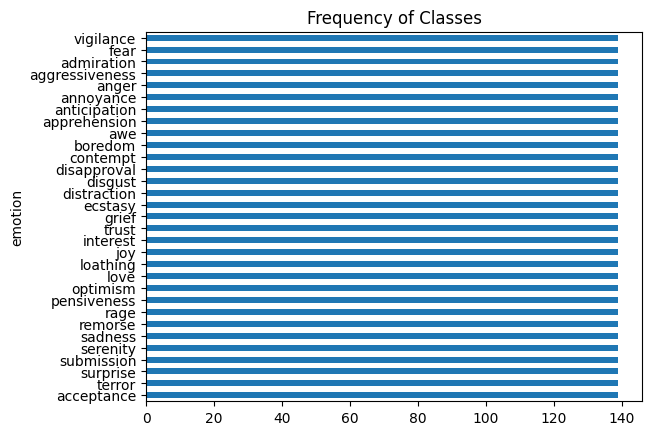

In [ ]:
resampled_df["emotion"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

# **Fine-tuning**

In [ ]:
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

def tokenize(batch):
    return tokenizer(batch["lyrics"], padding=True, truncation=True, max_length=512)

In [ ]:
eval_df = pd.read_csv('/content/drive/MyDrive/CZ4034/eval_labeled_lyrics.csv')
len(eval_df), eval_df.columns

(1102,
 Index(['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics',
        'duration', 'genre', 'emotion', 'intensity'],
       dtype='object'))

In [ ]:
resampled_dataset = Dataset.from_pandas(resampled_df)
resampled_dataset

Dataset({
    features: ['lyrics', 'label', 'emotion'],
    num_rows: 4309
})

In [ ]:
eval_df["label"] = eval_df["emotion"].apply(lambda x: label2id[x])
eval_dataset = Dataset.from_pandas(eval_df)
eval_dataset

Dataset({
    features: ['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics', 'duration', 'genre', 'emotion', 'intensity', 'label'],
    num_rows: 1102
})

In [ ]:
resampled_encoded = resampled_dataset.map(tokenize, batched=True)
eval_encoded = eval_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/4309 [00:00<?, ? examples/s]

Map:   0%|          | 0/1102 [00:00<?, ? examples/s]

In [ ]:
resampled_encoded, eval_encoded

(Dataset({
     features: ['lyrics', 'label', 'emotion', 'input_ids', 'attention_mask'],
     num_rows: 4309
 }),
 Dataset({
     features: ['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics', 'duration', 'genre', 'emotion', 'intensity', 'label', 'input_ids', 'attention_mask'],
     num_rows: 1102
 }))

In [ ]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T


,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [ ]:
!huggingface-cli login --token HUGGINGFACE_TOKEN
# from huggingface_hub import notebook_login
# notebook_login()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)
         .to(device))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 16
logging_steps = len(resampled_encoded) // batch_size
new_model = f"emotional-distilbert-3"
training_args = TrainingArguments(output_dir=new_model,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.0001,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='eval_loss',
                                  greater_is_better=False,
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=resampled_encoded,
                  eval_dataset=eval_encoded,
                  tokenizer=tokenizer,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
                  )
trainer.train();


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.785700,2.706043,0.250454,0.230146,0.388143,0.250454
2,1.418300,2.166545,0.369328,0.367361,0.429526,0.369328
3,0.621000,1.869073,0.441924,0.434291,0.454497,0.441924
4,0.235200,1.840635,0.440109,0.433342,0.457142,0.440109
5,0.081600,1.989181,0.447368,0.433461,0.451756,0.447368
6,0.028400,2.108026,0.434664,0.422420,0.436509,0.434664
7,0.014100,2.151467,0.442831,0.425819,0.440750,0.442831


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

In [ ]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1712764770.c6325f312c89.1856.0:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sherelyn912/emotional-distilbert-3/commit/964a3ceef91df0a2809cbeae04eb5540f57008ae', commit_message='End of training', commit_description='', oid='964a3ceef91df0a2809cbeae04eb5540f57008ae', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
for e in trainer.state.log_history:
    print(e.keys())

dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate',

# **Evaluation metrics**

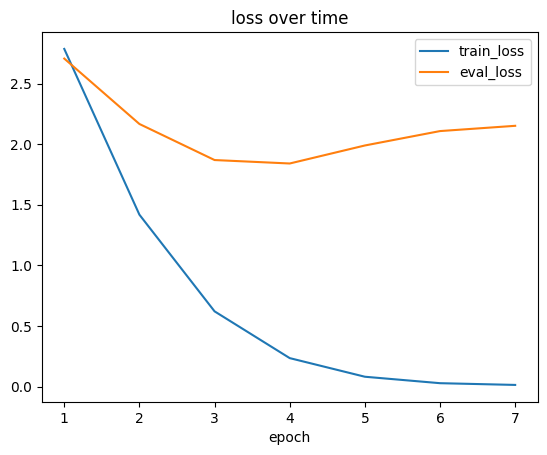

In [ ]:
train = trainer.state.log_history[:-1:2]
eval = trainer.state.log_history[1:-1:2]
train_loss = pd.DataFrame([epoch['loss'] for epoch in train], columns=['train_loss'])
train_loss['epoch'] = range(1, len(train_loss) + 1)
eval_loss = pd.DataFrame([[epoch['eval_loss'],epoch['eval_accuracy'],epoch['eval_f1'],epoch['eval_precision'],epoch['eval_recall']] for epoch in eval], columns=['eval_loss','eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall'])
eval_loss['epoch'] = range(1, len(eval_loss) + 1)
ax = train_loss.plot(x="epoch", y="train_loss")
eval_loss.plot(x="epoch", y="eval_loss", ax=ax)
plt.title("loss over time")
plt.show()

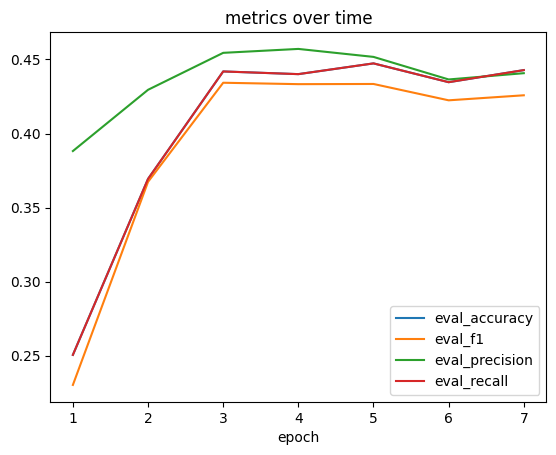

In [ ]:
ax2 = eval_loss.plot(x="epoch", y="eval_accuracy")
eval_loss.plot(x="epoch", y="eval_f1", ax=ax2)
eval_loss.plot(x="epoch", y="eval_precision", ax=ax2)
eval_loss.plot(x="epoch", y="eval_recall", ax=ax2)
plt.title("metrics over time")
plt.show()

# **Labelling all 20,000 rows of data**

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/CZ4034/finalfinalfinalfinalfinal.csv")
test_df

,artist,album,track,track_id,lyrics,duration,genre,release_date,explicit
0,The Weeknd,The Highlights (Deluxe),Die For You,2vz6HIZBaQOnWCH7kKhKQH,I'm findin' ways to articulate The feeling I'm...,4 minutes 20 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,False
1,The Weeknd,The Highlights (Deluxe),Starboy (feat. Daft Punk),218WdV0d4ijtTtPTKGuf1E,"I'm tryna put you in the worst mood, ah P1 cle...",3 minutes 50 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True
2,The Weeknd,The Highlights (Deluxe),Save Your Tears,6YckHetPOkzxtXXaYx0Gt1,"Ooh Na-na, yeah I saw you dancing in a crowded...",3 minutes 35 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True
3,The Weeknd,The Highlights (Deluxe),Blinding Lights,04948IGlqY1vSh7AHbueiQ,Yeah ♪ I've been tryna call I've been on my ow...,3 minutes 20 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,False
4,The Weeknd,The Highlights (Deluxe),In Your Eyes,4SD0V2HMxkBupk6ml9alm4,"Oh, yeah I just pretend, uh That I'm in the da...",3 minutes 57 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True
...,...,...,...,...,...,...,...,...,...
20794,Fall Out Boy,So Sick,So Sick - (BBC Radio 1 - Live Lounge),0Csc6pK1zv3k071tSWqJ5D,Gotta change my answering machine Now that I'm...,2 minutes 54 seconds,"['emo', 'modern rock', 'pop', 'rock']",2007-01-01,False
20795,Fall Out Boy,I'm Like A Lawyer With The Way I'm Always Tryi...,I'm Like A Lawyer With The Way I'm Always Tryi...,7eOlcfmf0J6rvWQrBVhorO,Last year's wishes are this year's apologies E...,3 minutes 36 seconds,"['emo', 'modern rock', 'pop', 'rock']",2007-01-01,False
20796,Fall Out Boy,I'm Like A Lawyer With The Way I'm Always Tryi...,Golden - Live From Hammersmith Palais,2nzAvHE8a63oX0PQTMq2UZ,How cruel is the golden rule? When the lives w...,2 minutes 35 seconds,"['emo', 'modern rock', 'pop', 'rock']",2007-01-01,False
20797,Fall Out Boy,"""The Take Over, The Breaks Over""",Thriller - 2006/AOL Music Sessions,3Eljf6kcc09IJPjTvUH2nA,"Yeah, what you critics said would never happen...",3 minutes 23 seconds,"['emo', 'modern rock', 'pop', 'rock']",2007-01-01,False


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 32
id2label = {
    "0": "serenity",
    "1": "joy",
    "2": "ecstasy",
    "3": "love",
    "4": "acceptance",
    "5": "trust",
    "6": "admiration",
    "7": "submission",
    "8": "apprehension",
    "9": "fear",
    "10": "terror",
    "11": "awe",
    "12": "distraction",
    "13": "surprise",
    "14": "amazement",
    "15": "disapproval",
    "16": "pensiveness",
    "17": "sadness",
    "18": "grief",
    "19": "remorse",
    "20": "boredom",
    "21": "disgust",
    "22": "loathing",
    "23": "contempt",
    "24": "annoyance",
    "25": "anger",
    "26": "rage",
    "27": "aggressiveness",
    "28": "interest",
    "29": "anticipation",
    "30": "vigilance",
    "31": "optimism"

}

label2id = {
    "serenity": 0,
    "joy": 1,
    "ecstasy": 2,
    "love": 3,
    "acceptance": 4,
    "trust": 5,
    "admiration": 6,
    "submission": 7,
    "apprehension": 8,
    "fear": 9,
    "terror": 10,
    "awe": 11,
    "distraction": 12,
    "surprise": 13,
    "amazement": 14,
    "disapproval": 15,
    "pensiveness": 16,
    "sadness": 17,
    "grief": 18,
    "remorse": 19,
    "boredom": 20,
    "disgust": 21,
    "loathing": 22,
    "contempt": 23,
    "annoyance": 24,
    "anger": 25,
    "rage": 26,
    "aggressiveness": 27,
    "interest": 28,
    "anticipation": 29,
    "vigilance": 30,
    "optimism": 31
}


In [ ]:
model_name = "sherelyn912/emotional-distilbert-3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id).to(device))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
    return tokenizer(batch["lyrics"], padding=True, truncation=True, max_length=512)

def label(model, dataloader):
    data = []
    for batch in dataloader:
        inputs = {'input_ids': batch['input_ids'].to(device), 'attention_mask': batch['attention_mask'].to(device)}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        pred_labels = torch.argmax(logits, dim=1)
        batch['label'] = pred_labels.cpu().tolist()
        batch['explicit'] = batch['explicit'].cpu().tolist()
        batch['input_ids'] = batch['input_ids'].cpu().tolist()
        batch['attention_mask'] = batch['attention_mask'].cpu().tolist()
        df = pd.DataFrame.from_dict(batch)
        data.append(df)

    return data

In [ ]:
test_dataset = Dataset.from_pandas(test_df)
test_dataset

Dataset({
    features: ['artist', 'album', 'track', 'track_id', 'lyrics', 'duration', 'genre', 'release_date', 'explicit'],
    num_rows: 20799
})

In [ ]:
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/20799 [00:00<?, ? examples/s]

In [ ]:
test_dataset = test_dataset.with_format("torch")
test_dataset

NameError: name 'test_dataset' is not defined

In [ ]:
from torch.utils.data import DataLoader
import time

dataloader = DataLoader(test_dataset, batch_size=16)

# Label
start_time = time.time()
preds = label(model, dataloader)
end_time = time.time()

In [ ]:
result = pd.concat(preds)
result.head(10)

,artist,album,track,track_id,lyrics,duration,genre,release_date,explicit,input_ids,attention_mask,label
0,The Weeknd,The Highlights (Deluxe),Die For You,2vz6HIZBaQOnWCH7kKhKQH,I'm findin' ways to articulate The feeling I'm...,4 minutes 20 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,False,"[101, 1045, 1005, 1049, 2424, 2378, 1005, 3971...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",22
1,The Weeknd,The Highlights (Deluxe),Starboy (feat. Daft Punk),218WdV0d4ijtTtPTKGuf1E,"I'm tryna put you in the worst mood, ah P1 cle...",3 minutes 50 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True,"[101, 1045, 1005, 1049, 3046, 2532, 2404, 2017...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",27
2,The Weeknd,The Highlights (Deluxe),Save Your Tears,6YckHetPOkzxtXXaYx0Gt1,"Ooh Na-na, yeah I saw you dancing in a crowded...",3 minutes 35 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True,"[101, 1051, 11631, 6583, 1011, 6583, 1010, 339...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",17
3,The Weeknd,The Highlights (Deluxe),Blinding Lights,04948IGlqY1vSh7AHbueiQ,Yeah ♪ I've been tryna call I've been on my ow...,3 minutes 20 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,False,"[101, 3398, 100, 1045, 1005, 2310, 2042, 3046,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",17
4,The Weeknd,The Highlights (Deluxe),In Your Eyes,4SD0V2HMxkBupk6ml9alm4,"Oh, yeah I just pretend, uh That I'm in the da...",3 minutes 57 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True,"[101, 2821, 1010, 3398, 1045, 2074, 9811, 1010...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",8
5,The Weeknd,The Highlights (Deluxe),Wicked Games,2x8uHFZoDuCwXDWhagx3Av,I left my girl back home I don't love her no m...,5 minutes 25 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True,"[101, 1045, 2187, 2026, 2611, 2067, 2188, 1045...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",29
6,The Weeknd,The Highlights (Deluxe),Can't Feel My Face,6iKlSDvBLyQP0AWygx01XT,And I know she'll be the death of me At least ...,3 minutes 33 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,False,"[101, 1998, 1045, 2113, 2016, 1005, 2222, 2022...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",17
7,The Weeknd,The Highlights (Deluxe),I Feel It Coming (feat. Daft Punk),2RzZMPIZIEomnQDq4eYIaW,"Yeah, ah Tell me what you really like Baby I c...",4 minutes 29 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,False,"[101, 3398, 1010, 6289, 2425, 2033, 2054, 2017...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3
8,The Weeknd,The Highlights (Deluxe),Pray For Me (with Kendrick Lamar),5W3Mi5lW7CIr3eTj1cc69p,I'm always ready for a war again (a war again)...,3 minutes 31 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True,"[101, 1045, 1005, 1049, 2467, 3201, 2005, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",30
9,The Weeknd,The Highlights (Deluxe),Heartless,7hIozlEu6hrYrtsXJj45A4,"Never need a bitch, I'm what a bitch need (Bit...",3 minutes 18 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True,"[101, 2196, 2342, 1037, 7743, 1010, 1045, 1005...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",22


In [ ]:
def assign_intensity(emotion):
    if emotion in ['joy', 'trust', 'fear', 'anticipation','anger','disgust', 'sadness','surprise', 'love','submission','awe','disapproval','remorse','contempt','aggressiveness','optimism']:
        return 'medium'
    elif emotion in ['ecstasy','admiration', 'terror','loathing','rage','vigilance','grief', 'amazement']:
        return 'high'
    else:
        return 'low'  # Default case, can be adjusted as needed

# Apply the function to the 'results' column and create/update the 'intensity' column
result["emotion"] = result["label"].apply(lambda x: id2label[str(x)])
result['intensity'] = result['emotion'].apply(assign_intensity)

In [ ]:
result = result.drop(columns=['input_ids', 'attention_mask', 'label'])
result.head(10)

,artist,album,track,track_id,lyrics,duration,genre,release_date,explicit,emotion,intensity
0,The Weeknd,The Highlights (Deluxe),Die For You,2vz6HIZBaQOnWCH7kKhKQH,I'm findin' ways to articulate The feeling I'm...,4 minutes 20 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,False,loathing,high
1,The Weeknd,The Highlights (Deluxe),Starboy (feat. Daft Punk),218WdV0d4ijtTtPTKGuf1E,"I'm tryna put you in the worst mood, ah P1 cle...",3 minutes 50 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True,aggressiveness,medium
2,The Weeknd,The Highlights (Deluxe),Save Your Tears,6YckHetPOkzxtXXaYx0Gt1,"Ooh Na-na, yeah I saw you dancing in a crowded...",3 minutes 35 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True,sadness,medium
3,The Weeknd,The Highlights (Deluxe),Blinding Lights,04948IGlqY1vSh7AHbueiQ,Yeah ♪ I've been tryna call I've been on my ow...,3 minutes 20 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,False,sadness,medium
4,The Weeknd,The Highlights (Deluxe),In Your Eyes,4SD0V2HMxkBupk6ml9alm4,"Oh, yeah I just pretend, uh That I'm in the da...",3 minutes 57 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True,apprehension,low
5,The Weeknd,The Highlights (Deluxe),Wicked Games,2x8uHFZoDuCwXDWhagx3Av,I left my girl back home I don't love her no m...,5 minutes 25 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True,anticipation,medium
6,The Weeknd,The Highlights (Deluxe),Can't Feel My Face,6iKlSDvBLyQP0AWygx01XT,And I know she'll be the death of me At least ...,3 minutes 33 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,False,sadness,medium
7,The Weeknd,The Highlights (Deluxe),I Feel It Coming (feat. Daft Punk),2RzZMPIZIEomnQDq4eYIaW,"Yeah, ah Tell me what you really like Baby I c...",4 minutes 29 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,False,love,medium
8,The Weeknd,The Highlights (Deluxe),Pray For Me (with Kendrick Lamar),5W3Mi5lW7CIr3eTj1cc69p,I'm always ready for a war again (a war again)...,3 minutes 31 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True,vigilance,high
9,The Weeknd,The Highlights (Deluxe),Heartless,7hIozlEu6hrYrtsXJj45A4,"Never need a bitch, I'm what a bitch need (Bit...",3 minutes 18 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True,loathing,high


In [ ]:
result.to_csv("/content/drive/MyDrive/CZ4034/final_labeled_dataset.csv", index=False)

# **Random Accuracy Test (Eval)**

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/CZ4034/eval_labeled_lyrics.csv")
df

,Unnamed: 0,artist,album,track,track_id,lyrics,duration,genre,emotion,intensity
0,22511,CoCoMelon,Nursery Rhymes by CoComelon,Hot Cross Buns,78RBF5yhod2Oc20aaeMOuU,"Hot cross buns\nHot cross buns\nOne a penny, t...",2 minutes 31 seconds,"[""children's music"", 'nursery', ""preschool chi...",joy,medium
1,22490,CoCoMelon,"CoComelon Kids Hits, Vol. 10",Train Song,7syG2CyMtm8zEk9VEPXAw2,I'm on a train\nI'm listening\nTo all the soun...,2 minutes 41 seconds,"[""children's music"", 'nursery', ""preschool chi...",joy,medium
2,8773,CoCoMelon,Let's Play!,Catch Song,0QZPciza5HuJifhvRfROXx,There are many things we can do\nWhen we play ...,2 minutes 21 seconds,"[""children's music"", 'nursery', ""preschool chi...",joy,medium
3,22420,CoCoMelon,Vehicle Fun with CoComelon,Farm Song,7tSPXIfI462pjBYid4gBXN,We're on the farm today\nSo many things to see...,2 minutes 42 seconds,"[""children's music"", 'nursery', ""preschool chi...",joy,medium
4,22350,CoCoMelon,Let's Play!,JJ's Scavenger Hunt,4QTrkpBDKe7M8M5tFQgap3,Let's go on a scavenger hunt\nAre you ready?\n...,2 minutes 30 seconds,"[""children's music"", 'nursery', ""preschool chi...",joy,medium
...,...,...,...,...,...,...,...,...,...,...
1097,7215,Teddy Swims,Lose Control (Piano Version),Lose Control - Live,2rmaYEjpHN90uuQRzniv8j,"Something's got a hold of me lately\nNo, I don...",4 minutes 0 seconds,[],grief,high
1098,20222,Teddy Swims,I've Tried Everything But Therapy (Part 1),Suitcase,0IDKI9KI71q4YPrW58hNtA,"Yeah, I'm sorry for the way I've been actin'\n...",2 minutes 48 seconds,[],remorse,medium
1099,7220,Teddy Swims,Sleep is Exhausting,dose,26ETsbVhx34daSYeBGmvgl,"Oh, babe, like a cold, cold hand on a stove, b...",3 minutes 0 seconds,[],ecstasy,high
1100,7251,Teddy Swims,Broke (feat. Thomas Rhett),Broke,72e1cs3TFqEx2BBMAwJ91k,"Yeah, yeah, yeah, yeah, yeah\nI'm so used to b...",2 minutes 40 seconds,[],joy,medium


In [ ]:
#Get a random subset from dataset
sample = df.sample(n=100)
sample

,Unnamed: 0,artist,album,track,track_id,lyrics,duration,genre,emotion,intensity
1050,19869,Michael Jackson,Immortal,Will You Be There - Immortal Version,5VwhnUGgcWpn43Vmn3UrfR,Hold me\nLike the River Jordan\nAnd I will the...,4 minutes 56 seconds,"['r&b', 'soul']",admiration,high
1066,14800,Benson Boone,Beautiful Things (Alternate Versions),Beautiful Things - Sped Up,7yqQNA3zo9oOIdWE0QEjIh,For a while there it was rough\nBut lately I'v...,2 minutes 34 seconds,['singer-songwriter pop'],sadness,medium
418,5542,Pitbull,El Mariel - Clean,Amanda Diva Skit,0lMKTt8RZTTIO7IdR94pXZ,"These words are written in blood, on red and w...",0 minutes 41 seconds,"['dance pop', 'miami hip hop', 'pop']",vigilance,high
136,14414,Playboi Carti,10s Hip-Hop Hits,"Beamer, Benz, Or Bentley",4TY4VeLpmiNY9otITGA8sn,"Beamer, Benz or Bentley\nBeamer, Benz or Bentl...",3 minutes 28 seconds,"['atl hip hop', 'plugg', 'pluggnb', 'rage rap'...",aggressiveness,medium
901,21586,Charlie Puth,Nine Track Mind (Deluxe Edition),Marvin Gaye (feat. Meghan Trainor),0aVAhfHMrNW7Mh0xknvW4j,Let's Marvin Gaye and get it on\nYou got the h...,3 minutes 10 seconds,"['pop', 'viral pop']",joy,medium
...,...,...,...,...,...,...,...,...,...,...
23,9178,Black Sabbath,Dehumanizer,"Neon Knights - Live From The Sundome, Tampa, F...",0k0ZVybxw6CjVHQ4THmYmS,"Oh no, here it comes again\nI can't remember w...",5 minutes 33 seconds,"['album rock', 'alternative metal', 'birmingha...",apprehension,low
1023,4999,Chris Brown,BREEZY - It's Giving Christmas,WE (Warm Embrace),2OSfNXeFnOYkUs0HaO8aTZ,"I can see your mind is overworked, boo (Yeah)\...",3 minutes 54 seconds,"['r&b', 'rap']",ecstasy,high
303,5614,Shawn Mendes,Wonder,24 Hours,385VOmGbguaPG57TgoW8Lh,All it'd take is 24 hours\nSign the check and ...,2 minutes 30 seconds,"['canadian pop', 'pop', 'viral pop']",pensiveness,low
1058,7045,Michael Jackson,The Definitive Collection,ABC,2VCUcIPY3i6pv9Nu9Vg6k3,"You went to school to learn, girl\nThings you ...",2 minutes 57 seconds,"['r&b', 'soul']",ecstasy,high


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 32
id2label = {
    "0": "serenity",
    "1": "joy",
    "2": "ecstasy",
    "3": "love",
    "4": "acceptance",
    "5": "trust",
    "6": "admiration",
    "7": "submission",
    "8": "apprehension",
    "9": "fear",
    "10": "terror",
    "11": "awe",
    "12": "distraction",
    "13": "surprise",
    "14": "amazement",
    "15": "disapproval",
    "16": "pensiveness",
    "17": "sadness",
    "18": "grief",
    "19": "remorse",
    "20": "boredom",
    "21": "disgust",
    "22": "loathing",
    "23": "contempt",
    "24": "annoyance",
    "25": "anger",
    "26": "rage",
    "27": "aggressiveness",
    "28": "interest",
    "29": "anticipation",
    "30": "vigilance",
    "31": "optimism"

}

label2id = {
    "serenity": 0,
    "joy": 1,
    "ecstasy": 2,
    "love": 3,
    "acceptance": 4,
    "trust": 5,
    "admiration": 6,
    "submission": 7,
    "apprehension": 8,
    "fear": 9,
    "terror": 10,
    "awe": 11,
    "distraction": 12,
    "surprise": 13,
    "amazement": 14,
    "disapproval": 15,
    "pensiveness": 16,
    "sadness": 17,
    "grief": 18,
    "remorse": 19,
    "boredom": 20,
    "disgust": 21,
    "loathing": 22,
    "contempt": 23,
    "annoyance": 24,
    "anger": 25,
    "rage": 26,
    "aggressiveness": 27,
    "interest": 28,
    "anticipation": 29,
    "vigilance": 30,
    "optimism": 31
}


In [ ]:
from transformers import pipeline
model_name = "sherelyn912/emotional-distilbert-3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id).to(device))

In [ ]:
def tokenize(batch):
    return tokenizer(batch["lyrics"], padding=True, truncation=True, max_length=512)

def label(model, dataloader):
    data = []
    for batch in dataloader:
        inputs = {'input_ids': batch['input_ids'].to(device), 'attention_mask': batch['attention_mask'].to(device)}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        pred_labels = torch.argmax(logits, dim=1)
        batch['label'] = pred_labels.cpu().tolist()
        batch['input_ids'] = batch['input_ids'].cpu().tolist()
        batch['attention_mask'] = batch['attention_mask'].cpu().tolist()
        df = pd.DataFrame.from_dict(batch)
        data.append(df)

    return data

In [ ]:
test_dataset = Dataset.from_pandas(sample)
test_dataset = test_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.with_format("torch")

from torch.utils.data import DataLoader

dataloader = DataLoader(test_dataset, batch_size=16)

# Label
preds = label(model, dataloader)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
result = pd.concat(preds)
result["pred_emotion"] = result["label"].apply(lambda x: id2label[str(x)])

In [ ]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(sample['emotion'].values, result['pred_emotion'].values)
print(f"Random sample accuracy: {accuracy}")

Random sample accuracy: 0.45


# **Random Accuracy Test (Guessing)**

In [5]:
df = pd.read_csv("/content/drive/MyDrive/CZ4034/finalfinalfinalfinalfinal.csv")
df1 =pd.read_csv("/content/drive/MyDrive/CZ4034/train_labeled_lyrics.csv")
df2 =pd.read_csv("/content/drive/MyDrive/CZ4034/eval_labeled_lyrics.csv")
df_filtered = df[~df['track_id'].isin(df1['track_id'])]
df_filtered = df[~df['track_id'].isin(df2['track_id'])]
df_filtered

,artist,album,track,track_id,lyrics,duration,genre,release_date,explicit
0,The Weeknd,The Highlights (Deluxe),Die For You,2vz6HIZBaQOnWCH7kKhKQH,I'm findin' ways to articulate The feeling I'm...,4 minutes 20 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,False
1,The Weeknd,The Highlights (Deluxe),Starboy (feat. Daft Punk),218WdV0d4ijtTtPTKGuf1E,"I'm tryna put you in the worst mood, ah P1 cle...",3 minutes 50 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True
2,The Weeknd,The Highlights (Deluxe),Save Your Tears,6YckHetPOkzxtXXaYx0Gt1,"Ooh Na-na, yeah I saw you dancing in a crowded...",3 minutes 35 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True
3,The Weeknd,The Highlights (Deluxe),Blinding Lights,04948IGlqY1vSh7AHbueiQ,Yeah ♪ I've been tryna call I've been on my ow...,3 minutes 20 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,False
4,The Weeknd,The Highlights (Deluxe),In Your Eyes,4SD0V2HMxkBupk6ml9alm4,"Oh, yeah I just pretend, uh That I'm in the da...",3 minutes 57 seconds,"['canadian contemporary r&b', 'canadian pop', ...",2024-02-09,True
...,...,...,...,...,...,...,...,...,...
20794,Fall Out Boy,So Sick,So Sick - (BBC Radio 1 - Live Lounge),0Csc6pK1zv3k071tSWqJ5D,Gotta change my answering machine Now that I'm...,2 minutes 54 seconds,"['emo', 'modern rock', 'pop', 'rock']",2007-01-01,False
20795,Fall Out Boy,I'm Like A Lawyer With The Way I'm Always Tryi...,I'm Like A Lawyer With The Way I'm Always Tryi...,7eOlcfmf0J6rvWQrBVhorO,Last year's wishes are this year's apologies E...,3 minutes 36 seconds,"['emo', 'modern rock', 'pop', 'rock']",2007-01-01,False
20796,Fall Out Boy,I'm Like A Lawyer With The Way I'm Always Tryi...,Golden - Live From Hammersmith Palais,2nzAvHE8a63oX0PQTMq2UZ,How cruel is the golden rule? When the lives w...,2 minutes 35 seconds,"['emo', 'modern rock', 'pop', 'rock']",2007-01-01,False
20797,Fall Out Boy,"""The Take Over, The Breaks Over""",Thriller - 2006/AOL Music Sessions,3Eljf6kcc09IJPjTvUH2nA,"Yeah, what you critics said would never happen...",3 minutes 23 seconds,"['emo', 'modern rock', 'pop', 'rock']",2007-01-01,False


In [6]:
sample = df_filtered.sample(n=100)
sample

,artist,album,track,track_id,lyrics,duration,genre,release_date,explicit
19084,Conan Gray,The Other Side,The Other Side,2mAy8zQhZJICLFUEVGQzbE,I've got tired eyes A black sky Making its hom...,2 minutes 52 seconds,"['bedroom pop', 'pop', 'pov: indie']",2019-02-08,False
16773,James Arthur,A Year Ago (Acoustic),A Year Ago - Acoustic,1J5Ne35kjDK1babqq9AsUc,"I miss you Your name's still on my coffee cup,...",3 minutes 1 seconds,"['pop', 'talent show', 'uk pop']",2023-05-31,False
15775,Linkin Park,Hybrid Theory (20th Anniversary Edition),My December - B-Side Rarities,3fY3mY4ER7KIuoz4yTvq9G,This is my December This is my time of the yea...,4 minutes 21 seconds,"['alternative metal', 'nu metal', 'post-grunge...",2020-10-09,False
16634,Barrett Strong,Motown Greatest Hits,Money (That's What I Want) - Single Version / ...,2BsQrbdxw9iDPJ5o1NEeEe,The best things in life are free But you can g...,2 minutes 39 seconds,"['r&b', 'soul']",2019-08-16,False
19806,AC/DC,Black Ice,Smash N Grab,6GIow0bPNRxQwCgCJODRHq,Come on and blow your mind You're out of time ...,4 minutes 6 seconds,"['australian rock', 'hard rock', 'rock']",2008-10-20,False
...,...,...,...,...,...,...,...,...,...
19707,Ray Charles,True Genius,"Baby, Don't You Cry",7adz2IqJlQopl1AxWbZuQT,"I say, baby, don't you cry You know I'll soon ...",2 minutes 34 seconds,"['album rock', 'classic rock', 'heartland rock...",2021-09-10,False
10762,DJ Snake,Playlist for Gamers,Middle,2vcyKh26vx4R8Un5IMpjan,Staring at two different views on your window ...,3 minutes 40 seconds,"['art pop', 'pop']",2021-08-18,False
18540,50 Cent,Before I Self-Destruct,Crime Wave,1aajFR7mUAa2OgIuecwnAq,"Yeah, yeah, yeah, yeah, yeah When the strap ou...",3 minutes 44 seconds,"['east coast hip hop', 'gangster rap', 'hip ho...",2009-01-01,True
12479,Tiësto,Just Be,Ur,2lrotPToOpH5QKRHvbLCwl,"Wish I was a better man, Wish I had a better p...",5 minutes 59 seconds,"['big room', 'brostep', 'dutch edm', 'edm', 'h...",2009-07-22,False


In [10]:
 labels = [
    "serenity",
    "joy",
    "ecstasy",
    "love",
    "acceptance",
    "trust",
    "admiration",
    "submission",
    "apprehension",
    "fear",
     "terror",
     "awe",
     "distraction",
     "surprise",
     "amazement",
     "disapproval",
     "pensiveness",
     "sadness",
     "grief",
     "remorse",
     "boredom",
     "disgust",
     "loathing",
     "contempt",
     "annoyance",
     "anger",
     "rage",
     "aggressiveness",
     "interest",
     "anticipation",
     "vigilance",
     "optimism"
 ]

 device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 32
id2label = {
    "0": "serenity",
    "1": "joy",
    "2": "ecstasy",
    "3": "love",
    "4": "acceptance",
    "5": "trust",
    "6": "admiration",
    "7": "submission",
    "8": "apprehension",
    "9": "fear",
    "10": "terror",
    "11": "awe",
    "12": "distraction",
    "13": "surprise",
    "14": "amazement",
    "15": "disapproval",
    "16": "pensiveness",
    "17": "sadness",
    "18": "grief",
    "19": "remorse",
    "20": "boredom",
    "21": "disgust",
    "22": "loathing",
    "23": "contempt",
    "24": "annoyance",
    "25": "anger",
    "26": "rage",
    "27": "aggressiveness",
    "28": "interest",
    "29": "anticipation",
    "30": "vigilance",
    "31": "optimism"

}

label2id = {
    "serenity": 0,
    "joy": 1,
    "ecstasy": 2,
    "love": 3,
    "acceptance": 4,
    "trust": 5,
    "admiration": 6,
    "submission": 7,
    "apprehension": 8,
    "fear": 9,
    "terror": 10,
    "awe": 11,
    "distraction": 12,
    "surprise": 13,
    "amazement": 14,
    "disapproval": 15,
    "pensiveness": 16,
    "sadness": 17,
    "grief": 18,
    "remorse": 19,
    "boredom": 20,
    "disgust": 21,
    "loathing": 22,
    "contempt": 23,
    "annoyance": 24,
    "anger": 25,
    "rage": 26,
    "aggressiveness": 27,
    "interest": 28,
    "anticipation": 29,
    "vigilance": 30,
    "optimism": 31
}

In [11]:
import numpy as np

# Generate random labels from the set of unique labels
random_labels = np.random.choice(labels, size=len(sample))

# Assuming you can add this array as a column to your dataset
sample['emotions'] = random_labels
sample

,artist,album,track,track_id,lyrics,duration,genre,release_date,explicit,emotions
19084,Conan Gray,The Other Side,The Other Side,2mAy8zQhZJICLFUEVGQzbE,I've got tired eyes A black sky Making its hom...,2 minutes 52 seconds,"['bedroom pop', 'pop', 'pov: indie']",2019-02-08,False,surprise
16773,James Arthur,A Year Ago (Acoustic),A Year Ago - Acoustic,1J5Ne35kjDK1babqq9AsUc,"I miss you Your name's still on my coffee cup,...",3 minutes 1 seconds,"['pop', 'talent show', 'uk pop']",2023-05-31,False,fear
15775,Linkin Park,Hybrid Theory (20th Anniversary Edition),My December - B-Side Rarities,3fY3mY4ER7KIuoz4yTvq9G,This is my December This is my time of the yea...,4 minutes 21 seconds,"['alternative metal', 'nu metal', 'post-grunge...",2020-10-09,False,distraction
16634,Barrett Strong,Motown Greatest Hits,Money (That's What I Want) - Single Version / ...,2BsQrbdxw9iDPJ5o1NEeEe,The best things in life are free But you can g...,2 minutes 39 seconds,"['r&b', 'soul']",2019-08-16,False,love
19806,AC/DC,Black Ice,Smash N Grab,6GIow0bPNRxQwCgCJODRHq,Come on and blow your mind You're out of time ...,4 minutes 6 seconds,"['australian rock', 'hard rock', 'rock']",2008-10-20,False,serenity
...,...,...,...,...,...,...,...,...,...,...
19707,Ray Charles,True Genius,"Baby, Don't You Cry",7adz2IqJlQopl1AxWbZuQT,"I say, baby, don't you cry You know I'll soon ...",2 minutes 34 seconds,"['album rock', 'classic rock', 'heartland rock...",2021-09-10,False,vigilance
10762,DJ Snake,Playlist for Gamers,Middle,2vcyKh26vx4R8Un5IMpjan,Staring at two different views on your window ...,3 minutes 40 seconds,"['art pop', 'pop']",2021-08-18,False,annoyance
18540,50 Cent,Before I Self-Destruct,Crime Wave,1aajFR7mUAa2OgIuecwnAq,"Yeah, yeah, yeah, yeah, yeah When the strap ou...",3 minutes 44 seconds,"['east coast hip hop', 'gangster rap', 'hip ho...",2009-01-01,True,grief
12479,Tiësto,Just Be,Ur,2lrotPToOpH5QKRHvbLCwl,"Wish I was a better man, Wish I had a better p...",5 minutes 59 seconds,"['big room', 'brostep', 'dutch edm', 'edm', 'h...",2009-07-22,False,pensiveness


In [12]:
from transformers import pipeline
model_name = "sherelyn912/emotional-distilbert-3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id).to(device))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [13]:
def tokenize(batch):
    return tokenizer(batch["lyrics"], padding=True, truncation=True, max_length=512)

def label(model, dataloader):
    data = []
    for batch in dataloader:
        inputs = {'input_ids': batch['input_ids'].to(device), 'attention_mask': batch['attention_mask'].to(device)}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        pred_labels = torch.argmax(logits, dim=1)
        batch['label'] = pred_labels.cpu().tolist()
        batch['explicit'] = batch['explicit'].cpu().tolist()
        batch['input_ids'] = batch['input_ids'].cpu().tolist()
        batch['attention_mask'] = batch['attention_mask'].cpu().tolist()
        df = pd.DataFrame.from_dict(batch)
        data.append(df)

    return data

In [14]:
test_dataset = Dataset.from_pandas(sample)
test_dataset = test_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.with_format("torch")

from torch.utils.data import DataLoader

dataloader = DataLoader(test_dataset, batch_size=16)

# Label
preds = label(model, dataloader)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [15]:
result = pd.concat(preds)
result["pred_emotion"] = result["label"].apply(lambda x: id2label[str(x)])

In [17]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(sample['emotions'].values, result['pred_emotion'].values)
print(f"Random sample accuracy: {accuracy}")

Random sample accuracy: 0.02


#**Performance Metrics**

In [ ]:
#Performance Metrics
num_records = len(result)
records_per_second = num_records / (end_time - start_time)
print(f"Records classified per second: {records_per_second}")

Records classified per second: 59.19747345373117
